## Modelo de regresion lineal sin los supuestos clasicos
Debido a que los supuestos en muchos casos suelen ser muy específicos, existen casos en los que se encuentra que no se cumplen con estos supuestos. Por ello, es importante saber identificarlos y encontrar una solucion a los siguientes:
1. Heterocedasticidad: varianza cambiante en el tiempo (supuesto 3)
2. Autocorrelacion: correlacion con rezagos (supuesto 3)
3. Endogeneidad en los regresores: correlacion de un regresor con el error (supuesto 2)
4. No normalidad en los errores: (supuesto 5)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm

# Heterocedasticidad
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from scipy.linalg import toeplitz

# Autocorrelacion
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson

import warnings
warnings.simplefilter("ignore")

### Heterocedasticidad
Se usara la base de datos "US Census Bureau", un censo realizado en EE. UU. para recoger informacion sobre factores socioeconomicos. La endogena es la `cantidad de personas en situacion de pobreza` y las exogenas son la `edad`, `porcentaje con colegio`, y `tasa de disponibilidad de propietarios de viviendas`

In [2]:
url = "https://gist.githubusercontent.com/sachinsdate/0b8ebc2b26afb67a1e83e752c69e1a25/raw/43b\
568aa2e29af519720a4a63c83d49b0529d05d/us_census_bureau_acs_2015_2019_subset.csv"

df = pd.read_csv(url)
df.to_csv("./data/us_census.csv")

df.rename(
    {"Percent_Households_Below_Poverty_Level": "poverty",
    "Median_Age": "age",
    "Homeowner_Vacancy_Rate": "vacancy",
    "Percent_Pop_25_And_Over_With_College_Or_Higher_Educ": "educ"},
    axis=1, inplace=True
)

df = df.dropna()

df.head()

,County,poverty,age,vacancy,educ
0,"Autauga, Alabama",14.7,38.2,1.4,26.6
1,"Baldwin, Alabama",10.5,43.0,3.3,31.9
2,"Barbour, Alabama",27.5,40.4,3.8,11.6
3,"Bibb, Alabama",18.4,40.9,1.5,10.4
4,"Blount, Alabama",14.2,40.7,0.7,13.1


In [47]:
X = df[["age", "vacancy", "educ"]]
y = df["poverty"]

model = sm.OLS(y, X)
results = model.fit()

store_params_ols = results.params
store_covar_ols = results.normalized_cov_params

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                poverty   R-squared (uncentered):                   0.782
Model:                            OLS   Adj. R-squared (uncentered):              0.782
Method:                 Least Squares   F-statistic:                              3850.
Date:                Sun, 01 Jan 2023   Prob (F-statistic):                        0.00
Time:                        13:22:48   Log-Likelihood:                         -11327.
No. Observations:                3219   AIC:                                  2.266e+04
Df Residuals:                    3216   BIC:                                  2.268e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Se puede definir la existencia de heterocedasticidad mediante lo siguiente:
1. Analisis grafico de los residuos
2. Test de White
3. Test de Breusch-Pagan

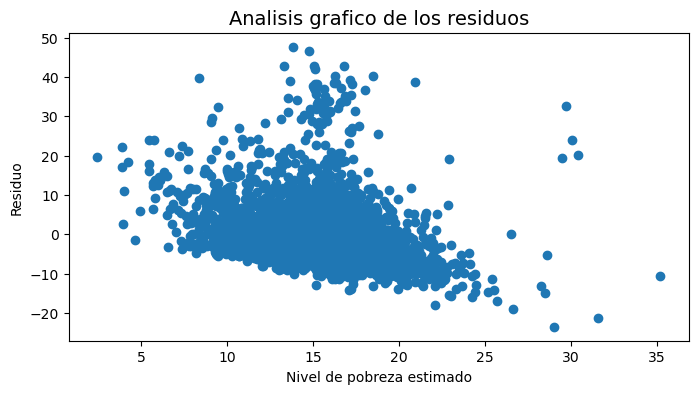

In [4]:
# Test 1
y_hat = results.predict(X)
residuos = results.resid

plt.figure(figsize=(8, 4))
plt.scatter(y_hat, residuos)

plt.title("Analisis grafico de los residuos", fontsize=14)
plt.xlabel("Nivel de pobreza estimado")
plt.ylabel("Residuo")

plt.show()

In [64]:
# Test 3
residuos = results.resid

test = het_breuschpagan(residuos, results.model.exog)
test = np.round(test, 3)

# H0: homocedasticidad en los errores
# H1: heterocedasticiadad en los erroes

print(f"El estadistico es {test[0]} y el p-value es {test[1]}")

El estadistico es 375.847 y el p-value es 0.0


Para solucionar el problema de heterocedasticidad se puede estimar por `Minimos Cuadrados Generalizados`

In [41]:
residuos = results.resid

eX = residuos[:-1].reset_index(drop=True)
eY = residuos[1:].reset_index(drop=True)

residuos_fit = sm.OLS(eY, eX).fit()
rho = residuos_fit.params[0]

order = toeplitz(np.arange(3219))
sigma = rho**order

In [46]:
model = sm.GLS(y, X, sigma=sigma)
results = model.fit()

store_params_gls = results.params
store_covar_gls = results.normalized_cov_params

print(results.summary())

                                 GLS Regression Results                                
Dep. Variable:                poverty   R-squared (uncentered):                   0.516
Model:                            GLS   Adj. R-squared (uncentered):              0.516
Method:                 Least Squares   F-statistic:                              1145.
Date:                Sun, 01 Jan 2023   Prob (F-statistic):                        0.00
Time:                        13:21:29   Log-Likelihood:                         -10768.
No. Observations:                3219   AIC:                                  2.154e+04
Df Residuals:                    3216   BIC:                                  2.156e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Comparativa de los parametros:

In [55]:
params = pd.DataFrame(
    data = {
        "OLS": store_params_ols,
        "GLS": store_params_gls
    }
)

params

,OLS,GLS
age,0.397883,0.365572
vacancy,0.873277,0.343937
educ,-0.138533,-0.098078


Comparativa de las matrices de covarianzas de los errores

In [62]:
print("Covarianza de errores de OLS")
print(store_covar_ols)
print("")
print("Covarianza de errores de por GLS")
print(store_covar_gls)

Covarianza de errores de OLS
              age   vacancy      educ
age      0.000001 -0.000008 -0.000002
vacancy -0.000008  0.000152  0.000001
educ    -0.000002  0.000001  0.000003

Covarianza de errores de por GLS
                  age   vacancy          educ
age      1.215634e-06 -0.000005 -9.532662e-07
vacancy -5.116471e-06  0.000094  1.168863e-06
educ    -9.532662e-07  0.000001  1.950414e-06


### Autocorrelacion
Se usara las series macroeconomicas de los Estados Unidos

In [ ]:
dta = sm.datasets.macrodata.load_pandas()
dta.data.to_csv("./data/macrodata.csv")

dta.data.head()

In [ ]:
X = dta.data[["realgdp"]]; y = dta.data["cpi"]
X = np.log(X); y = np.log(y)

X = X.diff(periods=4)*100; X = X.dropna()
y = y.diff(periods=4)*100; y = y.dropna()

# Añadir constante
X = sm.add_constant(X)

In [ ]:
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

Se puede definir la existencia de autocorrelacion mediante lo siguiente:
1. ACF, PACF
2. Test de Durbin-Watson
3. Test de Breusch-Pagan

In [ ]:
# Test 1
fig, ax = plt.subplots(1, 2, figsize=(10,3))

plot_acf(y, ax=ax[0], lags=10, title="ACF a la inflacion", alpha=0.05)
plot_pacf(y, ax=ax[1], lags=10, title="PACF al inflacion", alpha=0.05)

ax[0].set_ylim([-0.3, 1.2])
ax[1].set_ylim([-0.3, 1.2])

plt.subplots_adjust()
plt.savefig("./figures/acf_pacf_inflac.pdf")
plt.show()

In [ ]:
# Test 2
np.round(durbin_watson(results.resid), 3) # Autocorrelacion positiva

In [ ]:
# Test 3
def test_breusch_godfrey(model_results, maxlags):
    list = []

    for i in range(1, maxlags+1):
        values = acorr_breusch_godfrey(model_results, nlags=i)
        list.append([i, values[0], values[1]])
    
    table = pd.DataFrame(list, columns=["lags", "LM", "pvalue"])
    table.set_index("lags", inplace=True)
    
    # P-value < pvalue 
    table[f"pv<0.1"] = table["pvalue"]<0.1
    table[f"pv<0.05"] = table["pvalue"]<0.05
    table[f"pv<0.01"] = table["pvalue"]<0.01

    # Rounding
    table["LM"] = np.round(table["LM"], 3)
    table["pvalue"] = np.round(table["pvalue"], 3)

    return table


# La hipotesis nula es de no autocorrelacion
# Se rechaza la no autocorrelacion hasta 5 rezagos. 
test_breusch_godfrey(results, maxlags=5)

Inclusión de un rezago

In [ ]:
X = dta.data[["realgdp"]]; y = dta.data["cpi"]
X = np.log(X); y = np.log(y)

X = X.diff(periods=4)*100 
y = y.diff(periods=4)*100

X["cpi(-1)"] = y.shift(1) # Añadiendo un rezago
X = X.dropna(); y = y.dropna()

# Añadir constante
X = sm.add_constant(X)

y = y[1:]

In [ ]:
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

In [ ]:
print("Parece solucionar un poco la autocorrelacion en los dos primeros rezagos")
test_breusch_godfrey(results, maxlags=3)

### Endogeneidad

### No normalidad en errores

### Referencias:
* https://www.statsmodels.org/dev/diagnostic.html